In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf
from statsmodels.formula.api import logit

### EXPLORATORY DATA ANALYSIS

In [3]:
raw_data = pd.read_csv("/Users/lilitharutyunyan/Documents/GitHub/compas-analysis/compas-scores-two-years.csv", parse_dates=["c_jail_in", "c_jail_out"])
raw_data.shape

(7214, 53)

In [4]:

df = raw_data[["age", "c_charge_degree", "race", "age_cat", "score_text", "sex", "priors_count", 
          "days_b_screening_arrest", "decile_score", "is_recid", "two_year_recid", "c_jail_in", "c_jail_out"]]





In [5]:
df = df[
        (df["days_b_screening_arrest"]<=30) & 
        (df["days_b_screening_arrest"]>=-30) &
        (df["is_recid"]!=-1) & 
        (df["c_charge_degree"]!="O") #&
        #(dataframe["score_text"]!="N/A")
      ]

In [6]:
df.shape

(6172, 13)

In [7]:
category_cols = ['c_charge_degree', "race", "age_cat", 'score_text', 'sex', 'is_recid', 'two_year_recid']
df = df.apply(lambda s: s.astype('category') if s.name in category_cols else s)

### Demographic breakdown

* Higher COMPAS scores are slightly correlated with a longer length of stay

In [8]:
df["length_of_stay_days"] = (df.c_jail_out-df.c_jail_in).dt.days
np.round(df[["length_of_stay_days", "decile_score"]].corr()\
        .loc["length_of_stay_days","decile_score"],5)

#The loc() function helps us to retrieve data values from a dataset at an ease. Using the loc() function, 
#we can access the data values fitted in the particular row or column based on the index value passed to the function.


0.20748

In [9]:
np.corrcoef(df['length_of_stay_days'],df['decile_score'])

array([[1.        , 0.20747808],
       [0.20747808, 1.        ]])

* After filtering we have the following demographic breakdown:

In [10]:
df.age_cat.value_counts()

25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: age_cat, dtype: int64

In [11]:
df.race.value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

In [12]:
(df.race.value_counts(normalize=True)*100).map('{:,.2f}%'.format)

# With normalize set to True , returns the relative frequency by dividing all values by the sum of values.

African-American    51.44%
Caucasian           34.07%
Hispanic             8.25%
Other                5.56%
Asian                0.50%
Native American      0.18%
Name: race, dtype: object

In [13]:
df.score_text.value_counts()

Low       3421
Medium    1607
High      1144
Name: score_text, dtype: int64

In [14]:
pd.crosstab(df["sex"],df["race"])


race,African-American,Asian,Caucasian,Hispanic,Native American,Other
sex,,,,,,
Female,549,2,482,82,2,58
Male,2626,29,1621,427,9,285


In [15]:
df.sex.value_counts()

Male      4997
Female    1175
Name: sex, dtype: int64

In [16]:
(df.sex.value_counts(normalize=True)*100).map('{:,.2f}%'.format)

Male      80.96%
Female    19.04%
Name: sex, dtype: object

In [19]:
no_recid = np.sum(df['two_year_recid'] ==1)
print ('# of entries with two_ear_recid:', no_recid)
print ('% of entries with two_ear_recid:', np.round(no_recid/df.shape[0]*100,2))

# of entries with two_ear_recid: 2809
% of entries with two_ear_recid: 45.51


* Judges are often presented with two sets of scores from the Compas system -- one that classifies people into High, Medium and Low risk, and a corresponding decile score. There is a clear downward trend in the decile scores as those scores increase for white defendants.



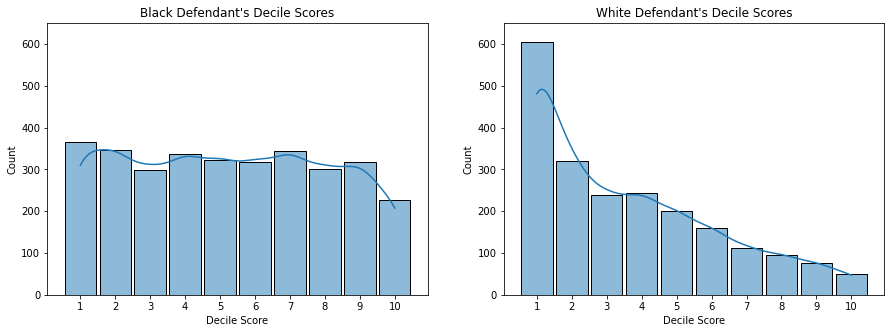

In [20]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
plt.setp(axes, ylim=(0,650), xticks=np.arange(1,11), xlabel="Decile Score")

scores_black = df[df["race"]=="African-American"]["decile_score"]
scores_white = df[df["race"]=="Caucasian"]["decile_score"]

sns.histplot(
    x=scores_black,
    bins=10, 
    ax=axes[0], 
    kde=True,
    shrink=.9,
    discrete=True
            )
axes[0].set_title("Black Defendant's Decile Scores")

sns.histplot(
    x=scores_white,
    bins=10, 
    ax=axes[1], 
    kde=True,
    shrink=.9,
    discrete=True
            )
axes[1].set_title("White Defendant's Decile Scores");

In [21]:
pd.crosstab(df["decile_score"],df["race"])

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score,,,,,,
1,365,15,605,159,0,142
2,346,4,321,89,2,60
3,298,5,238,73,1,32
4,337,0,243,47,0,39
5,323,1,200,39,0,19
6,318,2,160,27,2,20
7,343,1,113,28,2,9
8,301,2,96,14,0,7
9,317,0,77,17,2,7


### Racial Bias in Compas
* After filtering out bad rows, our first question is whether there is a significant difference in Compas scores between races. To do so we need to change some variables into factors, and run a logistic regression, comparing low scores to high scores.

In [23]:
#filter category columns
cols_cat = ['score_text','age_cat','sex','race','c_charge_degree']

#all columns of the subset
cols_df = ['score_text','sex','age_cat','race','priors_count','two_year_recid','c_charge_degree']

#define cat columns as category type
df.loc[:,cols_cat].astype('category')

#define data frame and do dummies coding for all cat columns
df_lr = pd.DataFrame(df, columns = cols_df)
df_lr = pd.get_dummies(data=df_lr,columns =cols_cat)

#bring Medium and High to 1 column
df_lr['score_text'] = df_lr['score_text_Medium'] + df_lr['score_text_High']

      
df = df_lr.rename(columns={"age_cat_Less than 25": "age_cat_Less_than_25", "age_cat_Greater than 45": "age_cat_Greater_than_45","race_Native American":"race_Native_American","race_African-American":"race_African_American"})    

formula = 'score_text ~ sex_Female + age_cat_Greater_than_45 + age_cat_Less_than_25 + race_African_American + race_Asian + race_Hispanic + race_Native_American + race_Other + priors_count + c_charge_degree_M + two_year_recid'

score_mod = logit(formula, data = df).fit()
print(score_mod.summary())

Optimization terminated successfully.
         Current function value: 0.499708
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             score_text   No. Observations:                 6172
Model:                          Logit   Df Residuals:                     6160
Method:                           MLE   Df Model:                           11
Date:                Mon, 13 Dec 2021   Pseudo R-squ.:                  0.2729
Time:                        16:58:15   Log-Likelihood:                -3084.2
converged:                       True   LL-Null:                       -4241.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.5255      0.079    -19.430      0.000      -1.679   

* Black defendants are 45% more likely than white defendants to receive a higher score correcting for the seriousness of their crime, previous arrests, and future criminal behavior.

In [28]:
control = np.exp(-1.5255) / (1+np.exp(-1.5255))
#As white and male are the base categorical variables, control is the probability of white man between 25-45 to receive a higher score.

In [27]:
(np.exp(-1.5255+0.4772)+np.exp(0.4772)) / (1+np.exp(-1.5225+0.4772))

1.4516933414107756

* Women are 19.4% more likely than men to get a higher score.

In [29]:
np.exp(0.22127) / (1-control + (control * np.exp(0.22127)))

1.1947961876689026

* Most surprisingly, people under 25 are 2.5 times as likely to get a higher score as middle aged defendants.

In [30]:
np.exp(1.3084) / (1-control + (control * np.exp(1.3084)))

2.496107351371129

### Risk of Violent Recedivism

* Compas also offers a score that aims to measure a persons risk of violent recidivism, which has a similar overall accuracy to the Recidivism score. As before, we can use a logistic regression to test for racial bias.

In [31]:

raw_data = pd.read_csv("../../data-ProPublica/compas-scores-two-years-violent.csv", parse_dates=["c_jail_in", "c_jail_out"])
raw_data.shape[0] 

4743

In [32]:
# Select columns of interest and store as new df
df = raw_data[["age", "c_charge_degree", "race", "age_cat", "v_score_text", "sex", "priors_count", 
          "days_b_screening_arrest", "v_decile_score", "is_recid", "two_year_recid", "c_jail_in", "c_jail_out"]]

# Filter rows as described by ProPublica
df = df[
        (df["days_b_screening_arrest"]<=30) & 
        (df["days_b_screening_arrest"]>=-30) &
        (df["is_recid"]!=-1) & 
        (df["c_charge_degree"]!="O") #&
        #(df["score_text"]!="N/A")
      ]

df.shape

(4020, 13)

In [33]:
df.age_cat.value_counts()

25 - 45            2300
Greater than 45     954
Less than 25        766
Name: age_cat, dtype: int64

In [34]:
df.race.value_counts()

African-American    1918
Caucasian           1459
Hispanic             355
Other                255
Asian                 26
Native American        7
Name: race, dtype: int64

In [35]:
df.v_score_text.value_counts()

Low       2913
Medium     828
High       279
Name: v_score_text, dtype: int64

In [38]:
print ('# of entries with two_year_recid:', df[(df['two_year_recid'] ==1) ].shape[0] / df.shape[0]*100)
print ('% of entries with two_year_recid:', df[(df['two_year_recid'] ==1) ].shape[0])

# of entries with two_year_recid: 16.218905472636816
% of entries with two_year_recid: 652


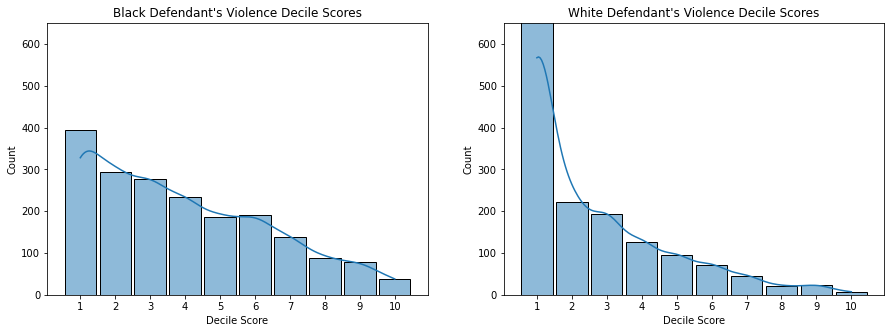

In [39]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
plt.setp(axes, ylim=(0,650), xticks=np.arange(1,11), xlabel="Decile Score")

scores_black = df[df["race"]=="African-American"]["v_decile_score"]
scores_white = df[df["race"]=="Caucasian"]["v_decile_score"]

sns.histplot(
    x=scores_black,
    bins=10, 
    ax=axes[0], 
    kde=True,
    shrink=.9,
    discrete=True
            )
axes[0].set_title("Black Defendant's Violence Decile Scores")

sns.histplot(
    x=scores_white,
    bins=10, 
    ax=axes[1], 
    kde=True,
    shrink=.9,
    discrete=True
            )
axes[1].set_title("White Defendant's Violence Decile Scores");

In [40]:
#Logistic Regression of Violence Decile Score

#filter category columns
cols_cat = ['v_score_text','age_cat','sex','race','c_charge_degree']

#all columns of the subset
cols_df = ['v_score_text','sex','age_cat','race','priors_count','two_year_recid','c_charge_degree']

#define cat columns as category type
df.loc[:,cols_cat].astype('category')

#define data frame and do dummies coding for all cat columns
df_lr = pd.DataFrame(df, columns = cols_df)
df_lr = pd.get_dummies(data=df_lr,columns =cols_cat)

#bring Medium and High to 1 column
df_lr['v_score_text'] = df_lr['v_score_text_Medium'] + df_lr['v_score_text_High']

      
df = df_lr.rename(columns={"age_cat_Less than 25": "age_cat_Less_than_25", "age_cat_Greater than 45": "age_cat_Greater_than_45","race_Native American":"race_Native_American","race_African-American":"race_African_American"})    

formula = 'v_score_text ~ sex_Female + age_cat_Greater_than_45 + age_cat_Less_than_25 + race_African_American + race_Asian + race_Hispanic + race_Native_American + race_Other + priors_count + c_charge_degree_M + two_year_recid'

score_mod = logit(formula, data = df).fit()
print(score_mod.summary())

Optimization terminated successfully.
         Current function value: 0.372983
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           v_score_text   No. Observations:                 4020
Model:                          Logit   Df Residuals:                     4008
Method:                           MLE   Df Model:                           11
Date:                Mon, 13 Dec 2021   Pseudo R-squ.:                  0.3662
Time:                        17:25:32   Log-Likelihood:                -1499.4
converged:                       True   LL-Null:                       -2365.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -2.2427      0.113    -19.802      0.000      -2.465   

* The violent score overpredicts recidivism for black defendants by 77.3% compared to white defendants. (between 25-45)

In [41]:
control = np.exp(-2.2427) / (1 + np.exp(-2.2427))
np.exp(0.6589) / (1 - control + (control * np.exp(0.6589 )))

1.7738715321327136

* Defendands under 25 are 7.4 times as likely to get a higher score as middle aged defendants.

In [42]:
np.exp(3.1459) / (1 - control + (control * np.exp(3.1459)))

7.4140359085177545

### Predictive Accuracy of COMPAS

* In order to test whether Compas scores do an accurate job of deciding whether an offender is Low, Medium or High risk, we ran a Cox Proportional Hazards model. Northpointe, the company that created COMPAS and markets it to Law Enforcement, also ran a Cox model in their validation study. We used the counting model and removed people when they were incarcerated. Due to errors in the underlying jail data, we need to filter out 32 rows that have an end date more than the start date. Considering that there are 13,334 total rows in the data, such a small amount of errors will not affect the results.

In [45]:
raw_data = pd.read_csv("../../data-ProPublica/cox-parsed.csv")
df_cp = raw_data.copy()

df_cp = df_cp[(df_cp["end"]>df_cp["start"])].dropna(subset=['score_text']).drop_duplicates(["id"])

df_cp.shape

(10314, 52)

In [46]:
df_cp = df_cp.rename(columns={"race": "race_factor", 'score_text': "score_factor"})

In [47]:
df_cp.score_factor.value_counts()

Low       5751
Medium    2611
High      1952
Name: score_factor, dtype: int64

In [48]:
df_cp.race_factor.value_counts()

African-American    5147
Caucasian           3569
Hispanic             944
Other                571
Asian                 51
Native American       32
Name: race_factor, dtype: int64

### Directions of the Racial Bias

* The above analysis shows that the Compas algorithm does overpredict African-American defendant's future recidivism, but we haven't yet explored the direction of the bias. We can discover fine differences in overprediction and underprediction by comparing Compas scores across racial lines.

### Risk of Violent Recidivism

* Compas also offers a score that aims to measure a persons risk of violent recidivism, which has a similar overall accuracy to the Recidivism score.

### Gender differences in Compas scores

* In terms of underlying recidivism rates, we can look at gender specific Kaplan Meier estimates. There is a striking difference between women and men.

In [49]:
female = df_cp[df_cp["sex"]=="Female"]
male = df_cp[df_cp["sex"]=="Male"]